# Bibliotecas utilizadas

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Tarea 1

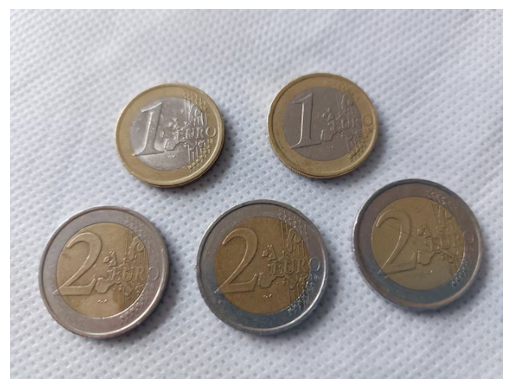

In [2]:
image = cv2.imread("imgs/coins_v2.jpg", cv2.IMREAD_COLOR_RGB)

plt.axis('off')
plt.imshow(image, cmap='gray')

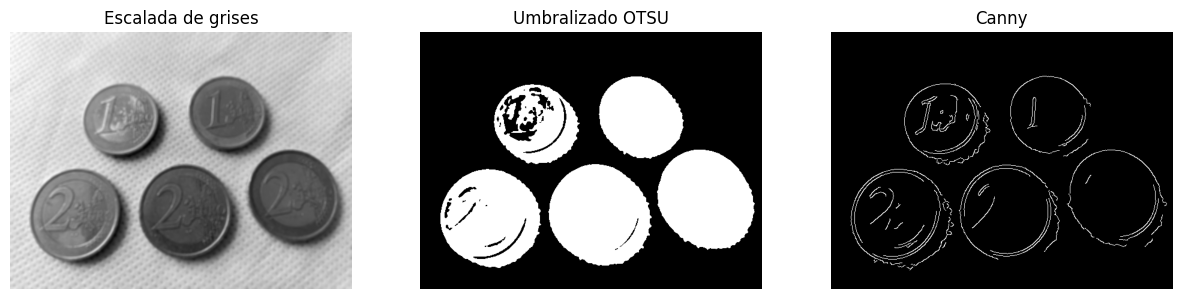

In [9]:
image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
image_gray = cv2.GaussianBlur(image_gray, (5, 5), 2)

canny = cv2.Canny(image_gray, 50, 125)

_, threshold_image = cv2.threshold(image_gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)


plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title('Escalada de grises')
plt.imshow(image_gray, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Umbralizado OTSU')
plt.imshow(threshold_image, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Canny')
plt.imshow(canny, cmap='gray')
plt.axis('off')

plt.savefig('imgs/preproceso_monedas.jpg')

## Para contornos

### Modelo para representar el dinero

In [10]:
from dataclasses import dataclass

@dataclass
class Coin:
    value: int
    diameter: float
    
    def __add__(self, other):
        if isinstance(other, Coin):
            return Money(self.value + other.value)
        elif isinstance(other, Money):
            return Money(self.value + other.value)
        return NotImplemented

    def __radd__(self, other):
        if other == 0:
            return Money(self.value)
        elif isinstance(other, Money):
            return Money(self.value + other.value)
        return NotImplemented
            

@dataclass
class Money:
    value: int

    def amount(self):
        return self.value / 100

### Clase desarrollada para el conteo

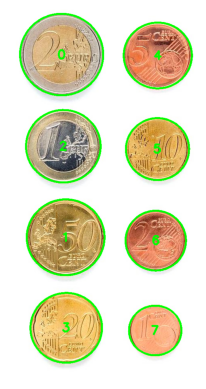

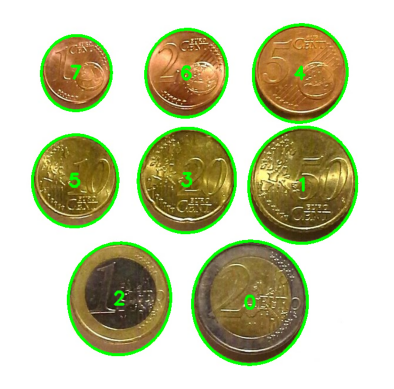

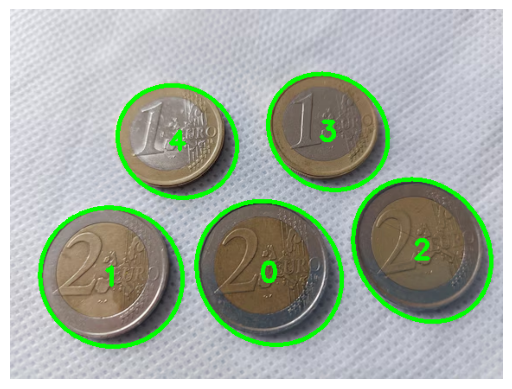

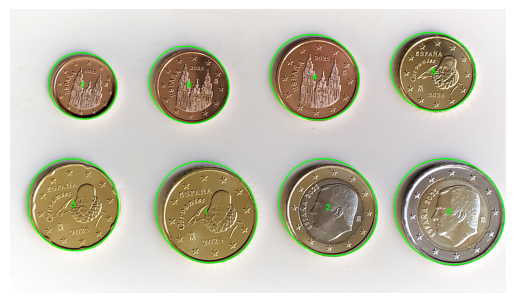

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


3.88


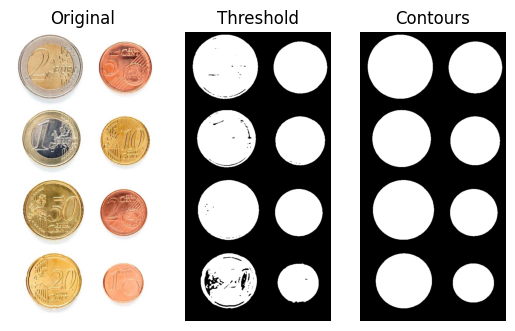

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


3.88


<Figure size 640x480 with 0 Axes>

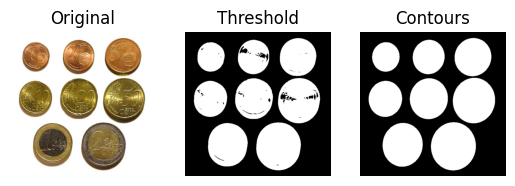

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


8.0


<Figure size 640x480 with 0 Axes>

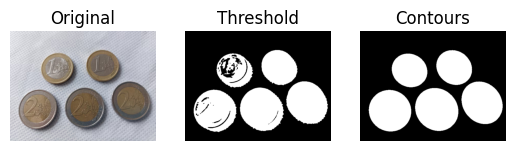

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


3.88


<Figure size 640x480 with 0 Axes>

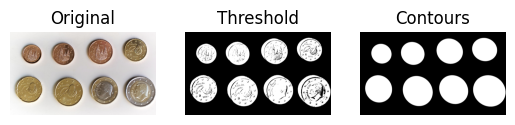

<Figure size 640x480 with 0 Axes>

In [ ]:
class MoneyCounter:
    coins_d = {
        '200': 25.75,
        '100': 23.25,
        '50': 24.25,
        '20': 22.25,
        '10': 19.75,
        '5': 21.25,
        '2': 18.75,
        '1': 16.25
    }

    coins_invert = {v: int(k) for k, v in coins_d.items()}

    def __init__(self, image):
        self.image = cv2.imread(image)
        self.thresh_image, self.canny = self.__preproccess_image()
        self.ellipses = self.__find_circular_contours(self.thresh_image)
        self.selected_coin = None
        self.selected_index = None
        self.PIXEL_MM_RATIO = None

    def show_detection_and_pick_coin(self, coin):
        self.selected_coin = coin
        drawed = self.__draw_found__ellipses_information()
        plt.imshow(drawed, cmap='gray')
        plt.axis('off')
        plt.show()
        self.selected_index = input(f"Selecciona el índice de la moneda con valor {coin}")
        return drawed, self.selected_index
        
    def __preproccess_image(self):
        gray = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
        blur = cv2.GaussianBlur(gray, (5, 5), 2)
        _, thresh_image = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        canny = cv2.Canny(blur, 50, 115)
        return thresh_image, canny
    
    def __calculate_circularity(self, contour):
        area = cv2.contourArea(contour)
        perimeter = cv2.arcLength(contour, True)

        if perimeter == 0:
            return False
        
        circularity = 4 * np.pi * (area / (perimeter * perimeter))
        return circularity >= 0.6 and area > 50

        
    def __find_circular_contours(self, image):
        contours, _ = cv2.findContours(
            image,
            cv2.RETR_EXTERNAL,
            cv2.CHAIN_APPROX_SIMPLE
        )

        contours = sorted(
            [c for c in contours if self.__calculate_circularity(c)],
            key=lambda c: cv2.contourArea(c), reverse=True
        )
        contours_ellipses = {}

        for i, c in enumerate(contours):
            ellipse = cv2.fitEllipse(c)
            contours_ellipses[i] = {
                'ellipse': ellipse,
                'center': ellipse[0],
                'width': min(ellipse[1]),
                'angle': ellipse[2]
            }
        
        return contours_ellipses

    def __draw_found__ellipses_information(self):
        image_copy = self.image.copy()
        image_copy = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)

        for i, c in enumerate(self.ellipses.values()):
            (x, y) = c['center']
            cv2.ellipse(image_copy, c['ellipse'], (0, 255, 0), 3)
            cv2.putText(
                image_copy,
                f"{i}",
                (int(x) - 10, int(y) + 10),
                cv2.FONT_HERSHEY_SIMPLEX,
                1,
                (0, 255, 0),
                3
            )

        return image_copy
    
    def __draw_found_ellipses_information_upon_empty_canvas(self):
        canvas = np.zeros(self.image.shape)

        if len(self.ellipses) != 0:
            for e in self.ellipses.values():
                cv2.ellipse(canvas, e['ellipse'], (255, 255, 255), -1)

        return canvas
        
    
    def do_the_math(self, debug):
        if len(self.ellipses) == 0:
            print('No se han encontrado figuras suficientes para hacer las mates.')
            return

        self.PIXEL_MM_RATIO = self.ellipses[int(self.selected_index)]['width'] / MoneyCounter.coins_d['100']

        current = []

        for c in self.ellipses.values():
            r = c['width']
            d = r / self.PIXEL_MM_RATIO
            k = min(MoneyCounter.coins_invert, key=lambda k: abs(k - d))
            current.append(Coin(MoneyCounter.coins_invert[k], k))

        debugged = {}

        if debug:
            debugged['original'] = cv2.cvtColor(self.image.copy(), cv2.COLOR_BGR2RGB)
            debugged['threshold'] = self.thresh_image
            debugged['contours'] = self.__draw_found_ellipses_information_upon_empty_canvas()
            debugged['money'] = sum(current).amount()

        return sum(current), current, debugged
        
if __name__ == '__main__':
    monedas = MoneyCounter('imgs/Monedas.jpg')
    shadow = MoneyCounter('imgs/coins_with_shadow.jpg')
    v2 = MoneyCounter('imgs/coins_v2.jpg')
    v3 = MoneyCounter('imgs/coins_v3.jpg')
    v4 = MoneyCounter('imgs/coins_v4.jpg')

    result_monedas, selected_monedas = monedas.show_detection_and_pick_coin(1)
    result_shadow, selected_shadow = shadow.show_detection_and_pick_coin(1)
    result_v2, selected_v2 = v2.show_detection_and_pick_coin(1)
    result_v3, selected_v3 = v3.show_detection_and_pick_coin(1)
    # result_v4, selected_v4 = v4.show_detection_and_pick_coin(1)

    _, _, d_monedas = monedas.do_the_math(True)
    _, _, d_shadow = shadow.do_the_math(True)
    _, _, d_v2 = v2.do_the_math(True)
    _, _, d_v3 = v3.do_the_math(True)
    # _, _, d_v4 = v4.do_the_math(True)

    debugs = [
        d_monedas, d_shadow, d_v2, d_v3
    ]

    for idx, d in enumerate(debugs):
        plt.figure()
        for sub, (title, image) in enumerate(d.items()):
            if title == 'money':
                continue

            plt.subplot(1, 3, sub + 1)
            plt.axis('off')
            plt.title(title.capitalize())
            plt.imshow(image, cmap='gray')

        print(d['money'])
        plt.savefig(f"imgs/conteo_{idx}.jpg")
        plt.show()
    


# Tarea 2